# MSIS2634 Natural Language Processing
## HW4

### Bhawana Mohta | bmohta@scu.edu  
### Nicolette Sauramba | nsauramba@scu.edu  
### Kyeongho Min | kmin@scu.edu

# HW on Trip Advisor Reviews

This dataset is from kaggle: https://www.kaggle.com/andrewmvd/trip-advisor-hotel-reviews

The dataset is also available here: https://drive.google.com/file/d/1YI16G173EVpfAB9f1xRKNB_2Zwy9-AMm/view?usp=sharing



In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.layers as L
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from wordcloud import WordCloud 
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import seaborn as sns


import numpy as np 
import pandas as pd

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords

import random as rn

import re
import string

In [2]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [3]:
df = pd.read_csv("tripadvisor_hotel_reviews.csv")
print(df.columns)
print("No of observations =", len(df))
df.head()

Index(['Review', 'Rating'], dtype='object')
No of observations = 20491


,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [4]:
df.groupby(['Rating']).count()

,Review
Rating,
1,1421
2,1793
3,2184
4,6039
5,9054


## Question 1 

Using the [Harvard Inquirer Dictionary](http://www.wjh.harvard.edu/~inquirer/inqdict.txt), count the number of positive and negative words in each review. Add two columns to the dataset, one for the count of positive words and the other for the count of negative words. 

Show the histogram of these word count columns. 

(You may want to stem the words in the Review column and those in inqdict before you match them and count words. Why?)

#### Cleaning

In [5]:
def text_cleaner(text):
    # lower the text
    text = text.lower()
    # remove punctuation
    text = "".join([w for w in text if w not in string.punctuation])    
    # remove digits
    text = re.sub(r'\d+',' ', text)    
    #remove stop words
    text = text.split(' ')
    text = " ".join([word for word in text if not word in stop_words])    
    #stemming
    text = text.split(' ')
    text = " ".join([ps.stem(w) for w in text])
    
    return text

ps = PorterStemmer()
stop_words = stopwords.words('english')

In [6]:
df['cleaned_Review'] = df['Review'].apply(text_cleaner)
df.head()

,Review,Rating,cleaned_Review
0,nice hotel expensive parking got good deal sta...,4,nice hotel expens park got good deal stay hote...
1,ok nothing special charge diamond member hilto...,2,ok noth special charg diamond member hilton de...
2,nice rooms not 4* experience hotel monaco seat...,3,nice room experi hotel monaco seattl good ho...
3,"unique, great stay, wonderful time hotel monac...",5,uniqu great stay wonder time hotel monaco loca...
4,"great stay great stay, went seahawk game aweso...",5,great stay great stay went seahawk game awesom...


In [7]:
## Read in a Harvard Inquirer file

f = open('inqdict.txt')
HIDict = f.read()
HIDict = HIDict.splitlines()
HIDict[:5]

['Entryword Source Pos Neg Pstv Affil Ngtv Hostile Strng Power Weak Subm Actv Psv Pleasure Pain Arousal EMOT Feel Virtue Vice Ovrst Undrst Acad Doctr Econ* Exch ECON Exprs Legal Milit Polit* POLIT Relig Role COLL Work Ritual Intrel Race Kin* MALE Female Nonadlt HU ANI PLACE Social Region Route Aquatic Land Sky Object Tool Food Vehicle Bldgpt Natobj Bodypt Comnobj Comform COM Say Need Goal Try Means Ach Persist Complt Fail Natpro Begin Vary Change Incr Decr Finish Stay Rise Move Exert Fetch Travel Fall Think Know Causal Ought Percv Comp Eval EVAL Solve Abs* ABS Qual Quan NUMB ORD CARD FREQ DIST Time* TIME Space POS DIM Dimn Rel COLOR Self Our You Name Yes No Negate Intrj IAV DAV SV IPadj IndAdj POWGAIN POWLOSS POWENDS POWAREN POWCON POWCOOP POWAPT POWPT POWDOCT POWAUTH POWOTH POWTOT RCTETH RCTREL RCTGAIN RCTLOSS RCTENDS RCTTOT RSPGAIN RSPLOSS RSPOTH RSPTOT AFFGAIN AFFLOSS AFFPT AFFOTH AFFTOT WLTPT WLTTRAN WLTOTH WLTTOT WLBGAIN WLBLOSS WLBPHYS WLBPSYC WLBPT WLBTOT ENLGAIN ENLLOSS ENLENDS

In [8]:
HIDict = HIDict[1:]
print(HIDict[:5])
print(len(HIDict))

['A H4Lvd DET ART  | article: Indefinite singular article--some or any one', 'ABANDON H4Lvd Neg Ngtv Weak Fail IAV AFFLOSS AFFTOT SUPV  |', 'ABANDONMENT H4 Neg Weak Fail Noun  |', 'ABATE H4Lvd Neg Psv Decr IAV TRANS SUPV  |', 'ABATEMENT Lvd Noun  ']
11895


##### Positive words in dictionary

In [9]:
poswords = [j for j in HIDict if "Pos" in j]  #using a list comprehension
poswords = [j.split()[0] for j in poswords]
poswords = [j.split("#")[0] for j in poswords]
poswords = unique(poswords)
poswords = [j.lower() for j in poswords]
print(poswords[:20])
print(len(poswords))

['abide', 'able', 'abound', 'absolve', 'absorbent', 'absorption', 'abundance', 'abundant', 'accede', 'accentuate', 'accept', 'acceptable', 'acceptance', 'accessible', 'accession', 'acclaim', 'acclamation', 'accolade', 'accommodate', 'accommodation']
1646


In [10]:
# stemming the positive words
poswords = [ps.stem(w) for w in poswords]
print(poswords[:20])

['abid', 'abl', 'abound', 'absolv', 'absorb', 'absorpt', 'abund', 'abund', 'acced', 'accentu', 'accept', 'accept', 'accept', 'access', 'access', 'acclaim', 'acclam', 'accolad', 'accommod', 'accommod']


##### negative words in dictionary

In [11]:
negwords = [j for j in HIDict if "Neg" in j]  #using a list comprehension
negwords = [j.split()[0] for j in negwords]
negwords = [j.split("#")[0] for j in negwords]
negwords = unique(negwords)
negwords = [j.lower() for j in negwords]
print(negwords[:20])
print(len(negwords))

['abandon', 'abandonment', 'abate', 'abdicate', 'abhor', 'abject', 'abnormal', 'abolish', 'abominable', 'abrasive', 'abrupt', 'abscond', 'absence', 'absent', 'absent-minded', 'absentee', 'absurd', 'absurdity', 'abuse', 'abyss']
2120


In [12]:
# stemming the negative words
negwords = [ps.stem(w) for w in negwords]
print(negwords[:20])

['abandon', 'abandon', 'abat', 'abdic', 'abhor', 'abject', 'abnorm', 'abolish', 'abomin', 'abras', 'abrupt', 'abscond', 'absenc', 'absent', 'absent-mind', 'absente', 'absurd', 'absurd', 'abus', 'abyss']


#### Create the functions that count positive words and negative words

In [13]:
def countPosWords(text):
    text = text.split(' ')
    text = [w for w in text if len(w) > 0]
    
    posmatches = set(text).intersection(set(poswords))
    
    return len(posmatches)

def countNegWords(text):
    text = text.split(' ')
    text = [w for w in text if len(w) > 0]
    
    negmatches = set(text).intersection(set(negwords))
    
    return len(negmatches)

#### Add columns and print out the dataframe

In [14]:
df['#_of_posWords'] = df['cleaned_Review'].apply(countPosWords)
df['#_of_negWords'] = df['cleaned_Review'].apply(countNegWords)

In [15]:
df.head(10)

,Review,Rating,cleaned_Review,#_of_posWords,#_of_negWords
0,nice hotel expensive parking got good deal sta...,4,nice hotel expens park got good deal stay hote...,15,5
1,ok nothing special charge diamond member hilto...,2,ok noth special charg diamond member hilton de...,29,21
2,nice rooms not 4* experience hotel monaco seat...,3,nice room experi hotel monaco seattl good ho...,25,11
3,"unique, great stay, wonderful time hotel monac...",5,uniqu great stay wonder time hotel monaco loca...,15,5
4,"great stay great stay, went seahawk game aweso...",5,great stay great stay went seahawk game awesom...,27,18
5,love monaco staff husband stayed hotel crazy w...,5,love monaco staff husband stay hotel crazi wee...,33,13
6,"cozy stay rainy city, husband spent 7 nights m...",5,cozi stay raini citi husband spent night mon...,21,3
7,"excellent staff, housekeeping quality hotel ch...",4,excel staff housekeep qualiti hotel chock staf...,17,8
8,"hotel stayed hotel monaco cruise, rooms genero...",5,hotel stay hotel monaco cruis room gener decor...,13,4
9,excellent stayed hotel monaco past w/e delight...,5,excel stay hotel monaco past delight recept st...,11,1


##### Plot the histogram of both columns

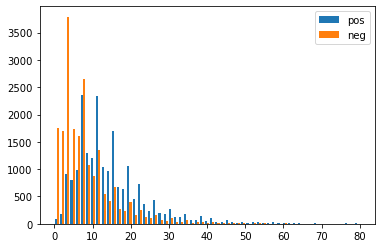

In [16]:
bins = np.linspace(0, 80, 60)
plt.hist([df['#_of_posWords'], df['#_of_negWords']], bins, label = ['pos', 'neg'])
plt.legend(loc = 'upper right')
plt.show()

## Train and Test datasets

Create these datasets once and save them for use in answering the 3 questions that follow. 

Use a 80:20 train-test split. 

#### I would like to add a new column that counts the number of words in each review

In [17]:
def countWords(text):
    text = text.split(' ')
    text = [w for w in text if len(w) > 0]
    return len(text)
df['#_of_ttlWords'] = df['cleaned_Review'].apply(countWords)
df.head()

,Review,Rating,cleaned_Review,#_of_posWords,#_of_negWords,#_of_ttlWords
0,nice hotel expensive parking got good deal sta...,4,nice hotel expens park got good deal stay hote...,15,5,80
1,ok nothing special charge diamond member hilto...,2,ok noth special charg diamond member hilton de...,29,21,230
2,nice rooms not 4* experience hotel monaco seat...,3,nice room experi hotel monaco seattl good ho...,25,11,199
3,"unique, great stay, wonderful time hotel monac...",5,uniqu great stay wonder time hotel monaco loca...,15,5,85
4,"great stay great stay, went seahawk game aweso...",5,great stay great stay went seahawk game awesom...,27,18,178


## Train and Test datasets

Create these datasets once and save them for use in answering the 3 questions that follow. 

Use a 80:20 train-test split. 

## Question 2

Fit a multi-category machine learning model to the data using only the two new columns you created as features and the Rating column as the label. 

Report the confusion matrix, accuracy, precision, recall, f1 score, Matthews correlation coefficient, ROC curve, and the AUC. Report these values on the train and test datasets. 

(Think about how you would like to manage the two features. Do you want to express them as a percentage of total words in the review? Do you want to normalize the columns by scaling?)

#### Create new dataframe

In [18]:
df2 = df[['Rating', '#_of_posWords', '#_of_negWords', '#_of_ttlWords']]
df2.head()

,Rating,#_of_posWords,#_of_negWords,#_of_ttlWords
0,4,15,5,80
1,2,29,21,230
2,3,25,11,199
3,5,15,5,85
4,5,27,18,178


##### I would like to add new column which is the percentage of poswords and negwords

In [19]:
df2['posRate'] = df2['#_of_posWords'] / df2['#_of_ttlWords']
df2['negRate'] = df2['#_of_negWords'] / df2['#_of_ttlWords']
df2.head()

,Rating,#_of_posWords,#_of_negWords,#_of_ttlWords,posRate,negRate
0,4,15,5,80,0.187500,0.062500
1,2,29,21,230,0.126087,0.091304
2,3,25,11,199,0.125628,0.055276
3,5,15,5,85,0.176471,0.058824
4,5,27,18,178,0.151685,0.101124


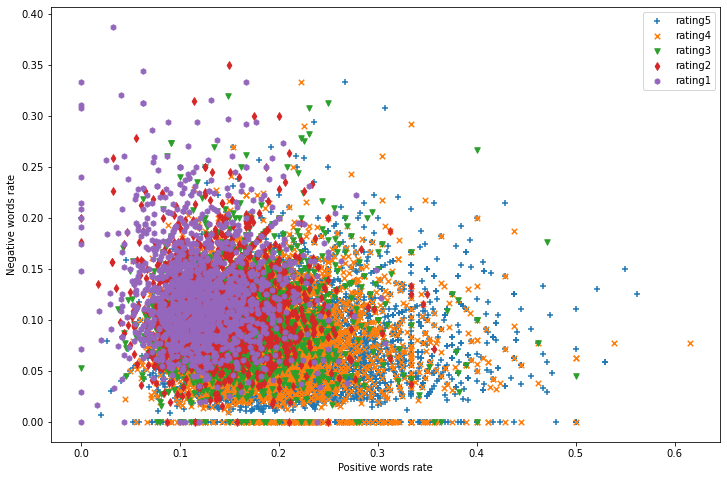

In [20]:
# plot the data
rating5 = df2[df2['Rating'].isin([5])]
rating4 = df2[df2['Rating'].isin([4])]
rating3 = df2[df2['Rating'].isin([3])]
rating2 = df2[df2['Rating'].isin([2])]
rating1 = df2[df2['Rating'].isin([1])]

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(rating5['posRate'], rating5['negRate'], s=30, marker = '+', label='rating5')
ax.scatter(rating4['posRate'], rating4['negRate'], s=30, marker = 'x', label='rating4')
ax.scatter(rating3['posRate'], rating3['negRate'], s=30, marker = 'v', label='rating3')
ax.scatter(rating2['posRate'], rating2['negRate'], s=30, marker = 'd', label='rating2')
ax.scatter(rating1['posRate'], rating1['negRate'], s=30, marker = 'h', label='rating1')

ax.legend()
ax.set_xlabel('Positive words rate')
ax.set_ylabel('Negative words rate')
plt.show()

In [21]:
# Features
X = df2.iloc[:, 4:6]
# Label
y = df2.iloc[:, 0:1]

In [22]:
X

,posRate,negRate
0,0.187500,0.062500
1,0.126087,0.091304
2,0.125628,0.055276
3,0.176471,0.058824
4,0.151685,0.101124
...,...,...
20486,0.150943,0.103774
20487,0.128205,0.025641
20488,0.147541,0.114754
20489,0.112466,0.111111


In [23]:
y

,Rating
0,4
1,2
2,3
3,5
4,5
...,...
20486,5
20487,4
20488,2
20489,1


In [24]:
X = np.matrix(X)
y = np.matrix(y)

In [25]:
X.shape, y.shape

((20491, 2), (20491, 1))

In [26]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 3)

In [27]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB


In [28]:
models = {
    "Logistic Regression": LogisticRegression(),
    "KNN": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Extra Trees": ExtraTreesClassifier(),
    "Gradiant Boosting": GradientBoostingClassifier(),
    "LBGM classifier": LGBMClassifier(),
    "Gaussian Naive Bayes": GaussianNB(),
    "Bernoulli Naive Bayes": BernoulliNB()
    # "XGB": XGBClassifier()
}

In [29]:
def fit_and_score(models, X_train, X_test, y_train, y_test):
    # Make a dictionary to keep model score
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        model.fit(X_train, y_train)
        #Evalute the model and append its score to model scores
        model_scores[name] = model.score(X_test, y_test)
    return model_scores

In [30]:
scores = fit_and_score(models, X_train, X_test, y_train, y_test)
scores

/Users/longmini/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/longmini/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
<ipython-input-29-9683f227888f>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
<ipython-input-29-9683f227888f>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
/Users

{'Logistic Regression': 0.46011222249329103,
 'KNN': 0.3952183459380337,
 'Random Forest': 0.39351061234447426,
 'Extra Trees': 0.3810685533056843,
 'Gradiant Boosting': 0.4637716516223469,
 'LBGM classifier': 0.44718223957062697,
 'Gaussian Naive Bayes': 0.4615759941449134,
 'Bernoulli Naive Bayes': 0.44108319102220056}

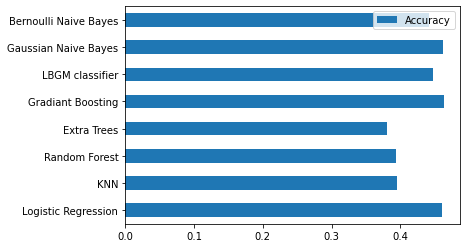

In [31]:
compare = pd.DataFrame(scores, index = ['Accuracy'])
compare.T.plot.barh()

In [32]:
# I would like to choose Gaussian Naive Bayes
clf = GaussianNB()
clf.fit(X_train, y_train)

/Users/longmini/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


GaussianNB()

##### For training dataset

In [33]:
train_accuracy = clf.score(X_train, y_train)
train_accuracy

0.4662030258662762

In [34]:
y_train_pred = clf.predict(X_train)

_________________________Classification Report_________________________
              precision    recall  f1-score   support

           1       0.23      0.39      0.29       667
           2       0.13      0.28      0.17       632
           3       0.00      0.20      0.01        41
           4       0.11      0.26      0.16      2064
           5       0.92      0.51      0.66     12988

    accuracy                           0.47     16392
   macro avg       0.28      0.33      0.26     16392
weighted avg       0.76      0.47      0.56     16392

_________________________Evaluation Metrics_________________________


Accuracy: 0.466203
Matthew correlation coefficient: 0.145825
Weighted Precision :0.755335
MAE :0.867801
RMSE :1.358482


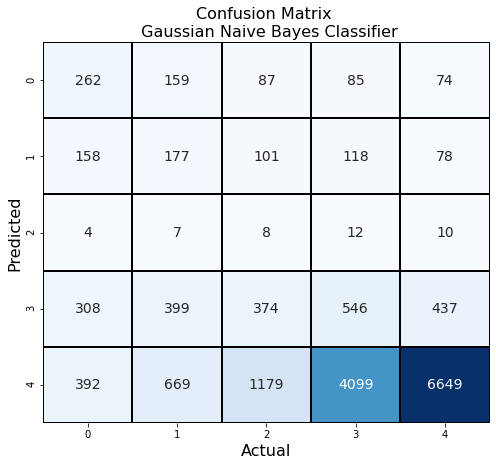

In [35]:
from sklearn.metrics import classification_report, matthews_corrcoef
from sklearn.metrics import confusion_matrix,mean_squared_error,mean_absolute_error,log_loss,accuracy_score,classification_report
from sklearn.metrics import precision_score

print("_"*25+"Classification Report"+"_"*25)
print(classification_report(y_train_pred,y_train,zero_division=0))
print("_"*25+"Evaluation Metrics"+"_"*25)
print("\n")
print("Accuracy: %f" % accuracy_score(y_train_pred,y_train))
print("Matthew correlation coefficient: %f" % matthews_corrcoef(y_train_pred, y_train))
print("Weighted Precision :%f" % precision_score(y_train_pred,y_train,average="weighted"))
print("MAE :%f" % mean_absolute_error(y_train_pred,y_train))
print("RMSE :%f" % mean_squared_error(y_train_pred,y_train,squared=False))

plt.figure(figsize=(8,7))
cm=confusion_matrix(y_train_pred,y_train)
g=sns.heatmap(cm,annot=True,fmt='d',linewidths=1,linecolor='black',
                  annot_kws={"size":14},cmap='Blues',cbar=False)

plt.xlabel('Actual',size=16)
plt.ylabel('Predicted',size=16)
plt.title('Confusion Matrix \n Gaussian Naive Bayes Classifier',size=16)
plt.show()

In [36]:
y_train

matrix([[4],
        [3],
        [5],
        ...,
        [5],
        [2],
        [5]])

In [37]:
# ROC_AUC curve, score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

y_train_binarize = label_binarize(y_train, classes = [1,2,3,4,5])
y_train_pred_proba = clf.predict_proba(X_train)

def plot_ROC_curve(y_test, y_score):
    n_classes = 5
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw = 2, 
                 label = 'ROC curve of class{0} (area = {1:0.2f})'.format(i+1, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC curve')
    plt.legend(loc="lower right")
    plt.show()



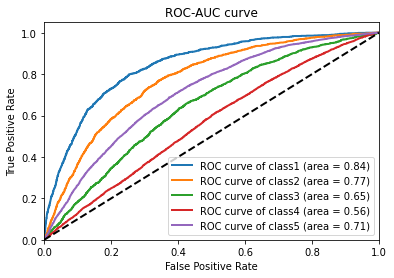

In [38]:
plot_ROC_curve(y_train_binarize, y_train_pred_proba)

##### For testing dataset

In [39]:
test_accuracy = clf.score(X_test, y_test)
test_accuracy

0.4615759941449134

In [40]:
y_test_pred = clf.predict(X_test)
y_test_pred

array([1, 2, 2, ..., 1, 5, 4])

_________________________Classification Report_________________________
              precision    recall  f1-score   support

           1       0.30      0.47      0.37       190
           2       0.10      0.22      0.13       170
           3       0.00      0.22      0.01         9
           4       0.11      0.26      0.15       505
           5       0.91      0.51      0.65      3225

    accuracy                           0.46      4099
   macro avg       0.28      0.33      0.26      4099
weighted avg       0.74      0.46      0.55      4099

_________________________Evaluation Metrics_________________________


Accuracy: 0.461576
Matthew correlation coefficient: 0.143320
Weighted Precision :0.743679
MAE :0.887534
RMSE :1.377157


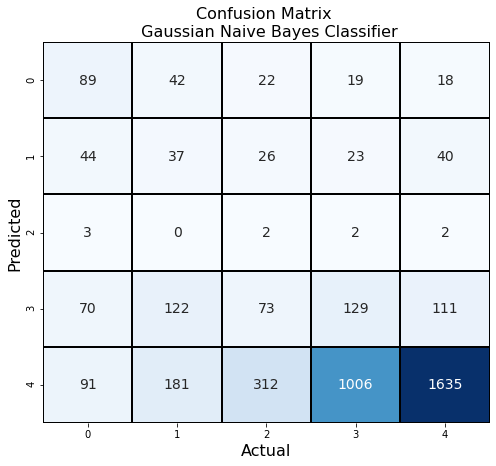

In [41]:
print("_"*25+"Classification Report"+"_"*25)
print(classification_report(y_test_pred,y_test,zero_division=0))
print("_"*25+"Evaluation Metrics"+"_"*25)
print("\n")
print("Accuracy: %f" % accuracy_score(y_test_pred,y_test))
print("Matthew correlation coefficient: %f" % matthews_corrcoef(y_test_pred, y_test))
print("Weighted Precision :%f" % precision_score(y_test_pred,y_test,average="weighted"))
print("MAE :%f" % mean_absolute_error(y_test_pred,y_test))
print("RMSE :%f" % mean_squared_error(y_test_pred,y_test,squared=False))

plt.figure(figsize=(8,7))
cm=confusion_matrix(y_test_pred,y_test)
g=sns.heatmap(cm,annot=True,fmt='d',linewidths=1,linecolor='black',
                  annot_kws={"size":14},cmap='Blues',cbar=False)

plt.xlabel('Actual',size=16)
plt.ylabel('Predicted',size=16)
plt.title('Confusion Matrix \n Gaussian Naive Bayes Classifier',size=16)
plt.show()

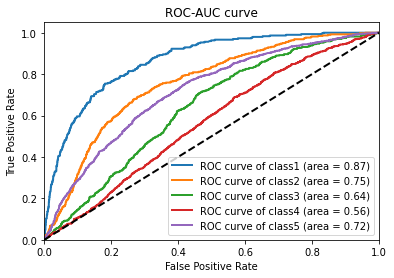

In [42]:
y_test_binarize = label_binarize(y_test, classes = [1,2,3,4,5])
y_test_pred_proba = clf.predict_proba(X_test)
plot_ROC_curve(y_test_binarize, y_test_pred_proba)

## Question 3

Fit a multi-category machine learning model to the data using only the Review column as features and the Rating column as the label. 

Report the confusion matrix, accuracy, precision, recall, f1 score, Matthews correlation coefficient, ROC curve, and the AUC. 

(Think about how you would like to manage the text column. Do you want to remove numbers, punctuation, stopwords, and do stemming?)

What framework did you choose? (lots of choices: Fasttext, spaCy, AutoGluon, TensorFlow, PyTorch, GLMnet, sklearn, etc.)

In [43]:
df3 = df[['cleaned_Review','Rating', '#_of_ttlWords']]
df3.head()

,cleaned_Review,Rating,#_of_ttlWords
0,nice hotel expens park got good deal stay hote...,4,80
1,ok noth special charg diamond member hilton de...,2,230
2,nice room experi hotel monaco seattl good ho...,3,199
3,uniqu great stay wonder time hotel monaco loca...,5,85
4,great stay great stay went seahawk game awesom...,5,178


In [44]:
# check the maximum number of words
max(df3['#_of_ttlWords'])

1861

In [45]:
X2 = df3['cleaned_Review']
y2 = df3['Rating']
# split the data
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.20, random_state = 3)

In [46]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X2_train, y2_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [47]:
from sklearn.metrics import classification_report
y2_pred = nb.predict(X2_test)
my_tags = ['class1','class2','class3','class4','class5']
print('accuracy %s' % accuracy_score(y2_pred, y2_test))
print(classification_report(y2_test, y2_pred, target_names=my_tags))

accuracy 0.44083922908026346
              precision    recall  f1-score   support

      class1       0.00      0.00      0.00       297
      class2       0.00      0.00      0.00       382
      class3       0.00      0.00      0.00       435
      class4       0.02      0.00      0.00      1179
      class5       0.45      1.00      0.62      1806

    accuracy                           0.44      4099
   macro avg       0.09      0.20      0.12      4099
weighted avg       0.20      0.44      0.27      4099



/Users/longmini/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/longmini/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/longmini/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
from sklearn.linear_model import SGDClassifier
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X2_train, y2_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=42,
                               tol=None))])

In [49]:
y2_pred2 = sgd.predict(X2_test)

print('accuracy %s' % accuracy_score(y2_pred2, y2_test))
print(classification_report(y2_test, y2_pred2,target_names=my_tags))

accuracy 0.5454989021712613
              precision    recall  f1-score   support

      class1       0.59      0.61      0.60       297
      class2       0.39      0.08      0.13       382
      class3       0.47      0.10      0.17       435
      class4       0.45      0.18      0.26      1179
      class5       0.56      0.98      0.71      1806

    accuracy                           0.55      4099
   macro avg       0.49      0.39      0.37      4099
weighted avg       0.51      0.55      0.46      4099



In [50]:
logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression())
               ])
# n_jobs=1, C=1e5, max_iter = 10000
logreg.fit(X2_train, y2_train)



y2_pred3 = logreg.predict(X2_test)

print('accuracy %s' % accuracy_score(y2_pred3, y2_test))
print(classification_report(y2_test, y2_pred3,target_names=my_tags))

/Users/longmini/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy 0.6235667235911198
              precision    recall  f1-score   support

      class1       0.70      0.62      0.66       297
      class2       0.48      0.33      0.39       382
      class3       0.48      0.31      0.38       435
      class4       0.52      0.52      0.52      1179
      class5       0.71      0.83      0.76      1806

    accuracy                           0.62      4099
   macro avg       0.58      0.52      0.54      4099
weighted avg       0.61      0.62      0.61      4099



### We chose logistic regression

##### For training dataset

In [51]:
train2_accuracy = logreg.score(X2_train, y2_train)
train2_accuracy

0.8008174719375305

In [52]:
y2_train_pred = logreg.predict(X2_train)

_________________________Classification Report_________________________
              precision    recall  f1-score   support

           1       0.85      0.91      0.88      1054
           2       0.71      0.85      0.78      1185
           3       0.52      0.84      0.64      1081
           4       0.74      0.73      0.74      4881
           5       0.92      0.82      0.86      8191

    accuracy                           0.80     16392
   macro avg       0.75      0.83      0.78     16392
weighted avg       0.82      0.80      0.81     16392

_________________________Evaluation Metrics_________________________


Accuracy: 0.800817
Matthew correlation coefficient: 0.707202
Weighted Precision :0.820191
MAE :0.248231
RMSE :0.612771


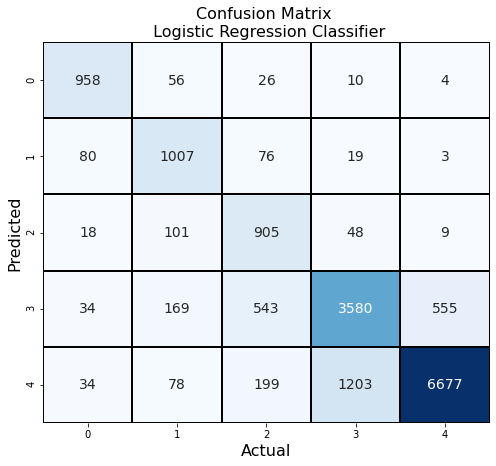

In [53]:
print("_"*25+"Classification Report"+"_"*25)
print(classification_report(y2_train_pred,y2_train,zero_division=0))
print("_"*25+"Evaluation Metrics"+"_"*25)
print("\n")
print("Accuracy: %f" % accuracy_score(y2_train_pred,y2_train))
print("Matthew correlation coefficient: %f" % matthews_corrcoef(y2_train_pred, y2_train))
print("Weighted Precision :%f" % precision_score(y2_train_pred,y2_train,average="weighted"))
print("MAE :%f" % mean_absolute_error(y2_train_pred,y2_train))
print("RMSE :%f" % mean_squared_error(y2_train_pred,y2_train,squared=False))

plt.figure(figsize=(8,7))
cm=confusion_matrix(y2_train_pred,y2_train)
g=sns.heatmap(cm,annot=True,fmt='d',linewidths=1,linecolor='black',
                  annot_kws={"size":14},cmap='Blues',cbar=False)

plt.xlabel('Actual',size=16)
plt.ylabel('Predicted',size=16)
plt.title('Confusion Matrix \n Logistic Regression Classifier',size=16)
plt.show()

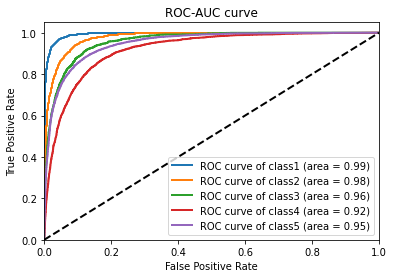

In [54]:
y2_train_binarize = label_binarize(y2_train, classes = [1,2,3,4,5])
y2_train_pred_proba = logreg.predict_proba(X2_train)
plot_ROC_curve(y2_train_binarize, y2_train_pred_proba)

##### for testing dataset

In [55]:
test2_accuracy = logreg.score(X2_test, y2_test)
test2_accuracy

0.6235667235911198

_________________________Classification Report_________________________
              precision    recall  f1-score   support

           1       0.62      0.70      0.66       264
           2       0.33      0.48      0.39       266
           3       0.31      0.48      0.38       283
           4       0.52      0.52      0.52      1183
           5       0.83      0.71      0.76      2103

    accuracy                           0.62      4099
   macro avg       0.52      0.58      0.54      4099
weighted avg       0.66      0.62      0.64      4099

_________________________Evaluation Metrics_________________________


Accuracy: 0.623567
Matthew correlation coefficient: 0.443456
Weighted Precision :0.658123
MAE :0.460112
RMSE :0.823241


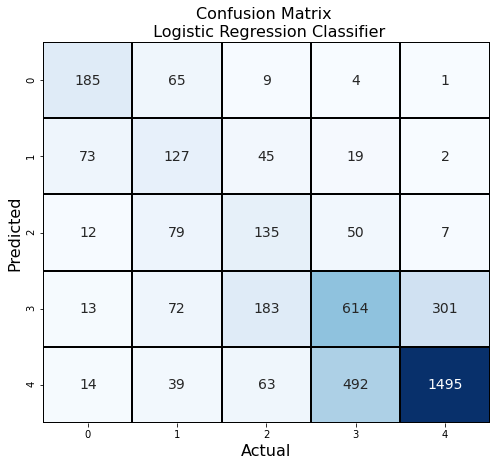

In [56]:
y2_test_pred = logreg.predict(X2_test)
print("_"*25+"Classification Report"+"_"*25)
print(classification_report(y2_test_pred,y2_test,zero_division=0))
print("_"*25+"Evaluation Metrics"+"_"*25)
print("\n")
print("Accuracy: %f" % accuracy_score(y2_test_pred,y2_test))
print("Matthew correlation coefficient: %f" % matthews_corrcoef(y2_test_pred, y2_test))
print("Weighted Precision :%f" % precision_score(y2_test_pred,y2_test,average="weighted"))
print("MAE :%f" % mean_absolute_error(y2_test_pred,y2_test))
print("RMSE :%f" % mean_squared_error(y2_test_pred,y2_test,squared=False))

plt.figure(figsize=(8,7))
cm=confusion_matrix(y2_test_pred,y2_test)
g=sns.heatmap(cm,annot=True,fmt='d',linewidths=1,linecolor='black',
                  annot_kws={"size":14},cmap='Blues',cbar=False)

plt.xlabel('Actual',size=16)
plt.ylabel('Predicted',size=16)
plt.title('Confusion Matrix \n Logistic Regression Classifier',size=16)
plt.show()

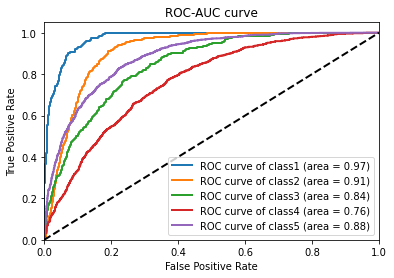

In [57]:
y2_test_binarize = label_binarize(y2_test, classes = [1,2,3,4,5])
y2_test_pred_proba = logreg.predict_proba(X2_test)
plot_ROC_curve(y2_test_binarize, y2_test_pred_proba)

## Question 4

Now try and use the two new columns and the Review column to build a model that uses both, the text and the positive/negative scores to construct a model. 

Report the confusion matrix, accuracy, precision, recall, f1 score, Matthews correlation coefficient, ROC curve, and the AUC.

In [58]:
df.head()

,Review,Rating,cleaned_Review,#_of_posWords,#_of_negWords,#_of_ttlWords
0,nice hotel expensive parking got good deal sta...,4,nice hotel expens park got good deal stay hote...,15,5,80
1,ok nothing special charge diamond member hilto...,2,ok noth special charg diamond member hilton de...,29,21,230
2,nice rooms not 4* experience hotel monaco seat...,3,nice room experi hotel monaco seattl good ho...,25,11,199
3,"unique, great stay, wonderful time hotel monac...",5,uniqu great stay wonder time hotel monaco loca...,15,5,85
4,"great stay great stay, went seahawk game aweso...",5,great stay great stay went seahawk game awesom...,27,18,178


In [59]:
df4 = df[['Rating','cleaned_Review', '#_of_posWords', '#_of_negWords', '#_of_ttlWords']]
df4.head()

,Rating,cleaned_Review,#_of_posWords,#_of_negWords,#_of_ttlWords
0,4,nice hotel expens park got good deal stay hote...,15,5,80
1,2,ok noth special charg diamond member hilton de...,29,21,230
2,3,nice room experi hotel monaco seattl good ho...,25,11,199
3,5,uniqu great stay wonder time hotel monaco loca...,15,5,85
4,5,great stay great stay went seahawk game awesom...,27,18,178


In [60]:
df4['posRate'] = df4['#_of_posWords'] / df4['#_of_ttlWords']
df4['negRate'] = df4['#_of_negWords'] / df4['#_of_ttlWords']
df4.head()

,Rating,cleaned_Review,#_of_posWords,#_of_negWords,#_of_ttlWords,posRate,negRate
0,4,nice hotel expens park got good deal stay hote...,15,5,80,0.187500,0.062500
1,2,ok noth special charg diamond member hilton de...,29,21,230,0.126087,0.091304
2,3,nice room experi hotel monaco seattl good ho...,25,11,199,0.125628,0.055276
3,5,uniqu great stay wonder time hotel monaco loca...,15,5,85,0.176471,0.058824
4,5,great stay great stay went seahawk game awesom...,27,18,178,0.151685,0.101124


In [61]:
features = df4.drop(['Rating', '#_of_posWords','#_of_negWords','#_of_ttlWords'], axis = 1)
target = df4['Rating']

In [62]:
features.head()

,cleaned_Review,posRate,negRate
0,nice hotel expens park got good deal stay hote...,0.187500,0.062500
1,ok noth special charg diamond member hilton de...,0.126087,0.091304
2,nice room experi hotel monaco seattl good ho...,0.125628,0.055276
3,uniqu great stay wonder time hotel monaco loca...,0.176471,0.058824
4,great stay great stay went seahawk game awesom...,0.151685,0.101124


In [63]:
target.head()

0    4
1    2
2    3
3    5
4    5
Name: Rating, dtype: int64

In [64]:
features.shape, target.shape

((20491, 3), (20491,))

In [65]:
from sklearn import preprocessing

# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

target = label_encoder.fit_transform(target)

In [66]:
X3_train, X3_test, y3_train, y3_test = train_test_split(features, target, test_size = 0.20, random_state = 3)

In [67]:
from keras.utils import to_categorical
y3_train = to_categorical(y3_train)
y3_test = to_categorical(y3_test)

#### Split the training data into text and rates

In [68]:
X3_train_text = X3_train['cleaned_Review']
X3_test_text = X3_test['cleaned_Review']
X3_train_rate = X3_train[['posRate', 'negRate']].values
X3_test_rate = X3_test[['posRate', 'negRate']].values

##### Tokenizing text data

In [69]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X3_train_text)

X3_train_text = tokenizer.texts_to_sequences(X3_train_text)
X3_test_text = tokenizer.texts_to_sequences(X3_test_text)

vocab_size = len(tokenizer.word_index) + 1
maxlen = max(df3['#_of_ttlWords'])

X3_train_text = pad_sequences(X3_train_text, padding='post', maxlen=maxlen)
X3_test_text = pad_sequences(X3_test_text, padding='post', maxlen=maxlen)

#### We will use GloVe word embeddings for creating word vectors:

In [70]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions

glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [71]:
from keras.layers import Input
input_1 = Input(shape=(maxlen,))
input_2 = Input(shape=(2,))

In [72]:
from keras.layers.embeddings import Embedding
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.layers.core import Activation, Dropout, Dense
from keras.layers.merge import Concatenate
from keras.models import Model

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(input_1)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(10, activation='relu')(input_2)
dense_layer_2 = Dense(10, activation='relu')(dense_layer_1)
concat_layer = Concatenate()([LSTM_Layer_1, dense_layer_2])
dense_layer_3 = Dense(10, activation='relu')(concat_layer)
output = Dense(5, activation='softmax')(dense_layer_3)
model = Model(inputs=[input_1, input_2], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1861)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1861, 100)    5381700     input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 10)           30          input_2[0][0]                    
_______________________________________________________________________________________

In [73]:
history = model.fit(x=[X3_train_text, X3_train_rate], y = y3_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
103/103 [==============================] - 514s 5s/step - loss: 1.3795 - acc: 0.4402 - val_loss: 1.3493 - val_acc: 0.4364
Epoch 2/10
103/103 [==============================] - 484s 5s/step - loss: 1.3252 - acc: 0.4435 - val_loss: 1.3049 - val_acc: 0.4364
Epoch 3/10
103/103 [==============================] - 439s 4s/step - loss: 1.2665 - acc: 0.4473 - val_loss: 1.2490 - val_acc: 0.4489
Epoch 4/10
103/103 [==============================] - 433s 4s/step - loss: 1.2248 - acc: 0.4623 - val_loss: 1.2342 - val_acc: 0.4614
Epoch 5/10
103/103 [==============================] - 438s 4s/step - loss: 1.2116 - acc: 0.4696 - val_loss: 1.2228 - val_acc: 0.4678
Epoch 6/10
103/103 [==============================] - 423s 4s/step - loss: 1.2084 - acc: 0.4692 - val_loss: 1.2204 - val_acc: 0.4684
Epoch 7/10
103/103 [==============================] - 451s 4s/step - loss: 1.2054 - acc: 0.4730 - val_loss: 1.2187 - val_acc: 0.4678
Epoch 8/10
103/103 [==============================] - 426s 4s/step - 

In [74]:
score = model.evaluate(x = [X3_test_text, X3_test_rate], y = y3_test, verbose = 1)
score

129/129 [==============================] - 63s 486ms/step - loss: 1.2126 - acc: 0.4691


[1.212626576423645, 0.4691388010978699]

##### We ran the ML model in AWS sagemaker, did not get a great score

##### for training dataset

In [75]:
y3_train_pred = model.predict([X3_train_text, X3_train_rate])

In [86]:
y3_train_pred

array([[0.07915116, 0.12242875, 0.14468972, 0.32573944, 0.32799086],
       [0.20984356, 0.2323598 , 0.1735283 , 0.22633344, 0.15793486],
       [0.02473801, 0.05170728, 0.09340039, 0.34573036, 0.4844239 ],
       ...,
       [0.00294979, 0.00982435, 0.03626355, 0.2809193 , 0.67004305],
       [0.18945372, 0.21988256, 0.1725117 , 0.24105673, 0.1770954 ],
       [0.21494944, 0.23529905, 0.17362213, 0.22268172, 0.15344758]],
      dtype=float32)

In [87]:
max(y3_train_pred[0])

0.32799086

In [93]:
y3_train_pred2 = []
for prob in y3_train_pred:
    maxnum = max(prob)
    for i in range(len(prob)):
        if (prob[i] == maxnum):
            y3_train_pred2.append(i)

In [81]:
y3_train

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [96]:
y3_train2 = []
for label in y3_train:
    for i in range(len(label)):
        if label[i] == 1:
            y3_train2.append(i)

_________________________Classification Report_________________________
              precision    recall  f1-score   support

           0       0.35      0.38      0.37      1045
           1       0.12      0.27      0.17       643
           2       0.00      0.00      0.00         0
           3       0.20      0.29      0.24      3294
           4       0.85      0.54      0.66     11410

    accuracy                           0.47     16392
   macro avg       0.31      0.30      0.29     16392
weighted avg       0.66      0.47      0.54     16392

_________________________Evaluation Metrics_________________________


Accuracy: 0.471022
Matthew correlation coefficient: 0.168142
Weighted Precision :0.661392
MAE :0.818448
RMSE :1.281461


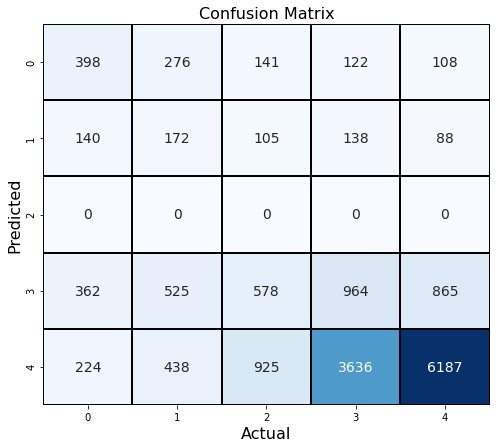

In [99]:
print("_"*25+"Classification Report"+"_"*25)
print(classification_report(y3_train_pred2,y3_train2,zero_division=0))
print("_"*25+"Evaluation Metrics"+"_"*25)
print("\n")
print("Accuracy: %f" % accuracy_score(y3_train_pred2,y3_train2))
print("Matthew correlation coefficient: %f" % matthews_corrcoef(y3_train_pred2, y3_train2))
print("Weighted Precision :%f" % precision_score(y3_train_pred2,y3_train2,average="weighted"))
print("MAE :%f" % mean_absolute_error(y3_train_pred2,y3_train2))
print("RMSE :%f" % mean_squared_error(y3_train_pred2,y3_train2,squared=False))

plt.figure(figsize=(8,7))
cm=confusion_matrix(y3_train_pred2,y3_train2)
g=sns.heatmap(cm,annot=True,fmt='d',linewidths=1,linecolor='black',
                  annot_kws={"size":14},cmap='Blues',cbar=False)

plt.xlabel('Actual',size=16)
plt.ylabel('Predicted',size=16)
plt.title('Confusion Matrix',size=16)
plt.show()

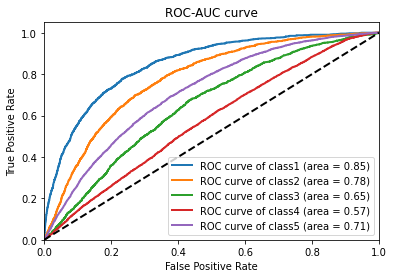

In [102]:
y3_train_binarize = label_binarize(y3_train, classes = [1,2,3,4,5])
y3_train_pred_proba = model.predict_on_batch([X3_train_text, X3_train_rate])
plot_ROC_curve(y3_train_binarize, y3_train_pred_proba)

##### For testing dataset

In [103]:
y3_test_pred = model.predict([X3_test_text, X3_test_rate])

In [104]:
y3_test_pred

array([[0.38886708, 0.3058752 , 0.14459911, 0.10858746, 0.05207117],
       [0.21566917, 0.23570757, 0.17363046, 0.22216834, 0.15282449],
       [0.21268925, 0.23400694, 0.17358817, 0.22429621, 0.15541942],
       ...,
       [0.3554017 , 0.29857808, 0.153041  , 0.1273437 , 0.06563547],
       [0.04921452, 0.08679087, 0.1228523 , 0.34268793, 0.3984544 ],
       [0.12358235, 0.16627467, 0.16318248, 0.2934162 , 0.25354436]],
      dtype=float32)

In [105]:
y3_test_pred2 = []
for prob in y3_test_pred:
    maxnum = max(prob)
    for i in range(len(prob)):
        if (prob[i] == maxnum):
            y3_test_pred2.append(i)

In [107]:
y3_test

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [115]:
y3_test2 = []
for label in y3_test:
    for i in range(len(label)):
        if label[i] == 1:
            y3_test2.append(i)

_________________________Classification Report_________________________
              precision    recall  f1-score   support

           0       0.43      0.42      0.42       307
           1       0.09      0.22      0.13       161
           2       0.00      0.00      0.00         0
           3       0.19      0.28      0.22       792
           4       0.85      0.54      0.66      2839

    accuracy                           0.47      4099
   macro avg       0.31      0.29      0.29      4099
weighted avg       0.66      0.47      0.54      4099

_________________________Evaluation Metrics_________________________


Accuracy: 0.469139
Matthew correlation coefficient: 0.172343
Weighted Precision :0.662247
MAE :0.840205
RMSE :1.309041


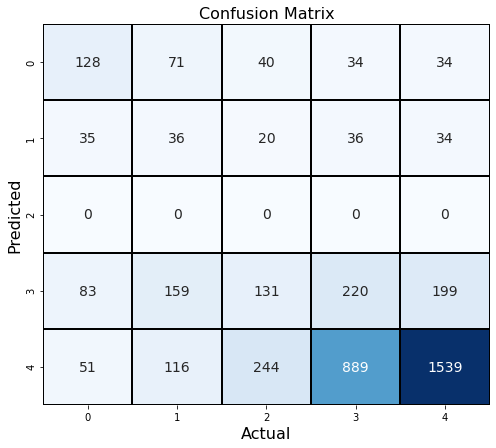

In [116]:
print("_"*25+"Classification Report"+"_"*25)
print(classification_report(y3_test_pred2,y3_test2,zero_division=0))
print("_"*25+"Evaluation Metrics"+"_"*25)
print("\n")
print("Accuracy: %f" % accuracy_score(y3_test_pred2,y3_test2))
print("Matthew correlation coefficient: %f" % matthews_corrcoef(y3_test_pred2, y3_test2))
print("Weighted Precision :%f" % precision_score(y3_test_pred2,y3_test2,average="weighted"))
print("MAE :%f" % mean_absolute_error(y3_test_pred2,y3_test2))
print("RMSE :%f" % mean_squared_error(y3_test_pred2,y3_test2,squared=False))

plt.figure(figsize=(8,7))
cm=confusion_matrix(y3_test_pred2,y3_test2)
g=sns.heatmap(cm,annot=True,fmt='d',linewidths=1,linecolor='black',
                  annot_kws={"size":14},cmap='Blues',cbar=False)

plt.xlabel('Actual',size=16)
plt.ylabel('Predicted',size=16)
plt.title('Confusion Matrix',size=16)
plt.show()

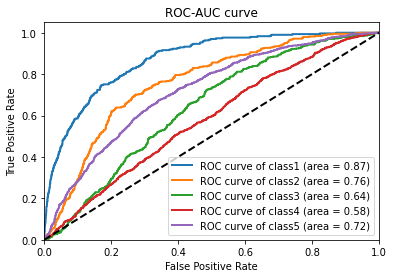

In [117]:
y3_test_binarize = label_binarize(y3_test, classes = [1,2,3,4,5])
y3_test_pred_proba = model.predict_on_batch([X3_test_text, X3_test_rate])
plot_ROC_curve(y3_test_binarize, y3_test_pred_proba)